In [25]:
import os
import gzip
import random
import platform
import warnings

import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from urllib.request import urlretrieve

In [26]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [27]:
# 현재 OS 및 파이썬 버전 확인
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"Python Version: {platform.python_version()}")

# 라이브러리 버전 확인
from importlib.metadata import version
print("numpy version : {}".format(version("numpy")))
print("matplotlib version : {}".format(version("matplotlib")))

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# matplotlib의 해상도 높이기
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Current OS: Linux
Python Version: 3.8.19
numpy version : 1.23.5
matplotlib version : 3.7.1


In [28]:
# MNIST를 다운받을 경로
url = 'https://raw.githubusercontent.com/fgnt/mnist/master/'

# MNIST를 저장할 디렉토리 (colab 사용 시, 기본 디렉토리는 `/content`)
# 만일 구글 드라이브를 마운트해서 사용할 경우, 사용하고자 하는 드라이브 위치를 `os.getcwd()` 부분에 덮어씌워 작성
dataset_dir = os.path.join('/home/pervinco/Datasets', 'MNIST')

# MNIST 데이터셋의 파일명 (딕셔너리)
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# 해당 경로가 없을 시 디렉토리 새로 생성
os.makedirs(dataset_dir, exist_ok=True)

# 해당 경로에 존재하지 않는 파일을 모두 다운로드
for filename in key_file.values():
    if filename not in os.listdir(dataset_dir):
        urlretrieve(url + filename, os.path.join(dataset_dir, filename))
        print("Downloaded %s to %s" % (filename, dataset_dir))

In [29]:
def _images(path):
    '''
    MNIST 데이터셋 이미지을 NumPy Array로 변환하여 불러오기
    '''
    # gzip 파일을 열고, 이미지를 읽어서 1차원 배열로 변환
    with gzip.open(path) as f:
        # 첫 16 바이트는 magic_number, n_imgs, n_rows, n_cols 의 정보이므로 무시
        pixels = np.frombuffer(f.read(), 'B', offset=16)

    # 28*28=784 이므로 784차원으로 reshape해준 뒤, 0~255의 값을 0~1로 정규화
    return pixels.reshape(-1, 28*28).astype('float32') / 255


def _onehot(integer_labels):
    '''
    라벨 데이터를 one-hot encoding 하기
    '''
    n_rows = len(integer_labels)        # 라벨 데이터의 길이
    n_cols = integer_labels.max() + 1   # 라벨 데이터의 최댓값 + 1

    # 0으로 채워진 (n_rows, n_cols) 크기의 행렬 생성
    onehot = np.zeros((n_rows, n_cols), dtype='uint8')
    # one-hot 행렬의 각 행에 해당하는 라벨을 1로 변경
    onehot[np.arange(n_rows), integer_labels] = 1

    return onehot

def _labels(path):
    '''
    MNIST 데이터셋 라벨을 NumPy Array로 변환하여 불러오기
    '''
    # gzip 파일을 열고, 라벨 데이터를 불러온 뒤, integer로 변환
    with gzip.open(path) as f:
        # 첫 8 바이트는 magic_number, n_labels 의 정보이므로 무시
        integer_labels = np.frombuffer(f.read(), 'B', offset=8)

    # one-hot 인코딩한 결과를 반환
    return _onehot(integer_labels)

In [30]:
# _images 함수를 이용하여 다운받은 학습/테스트 이미지를 numpy 행렬로 변환 및 전처리
X_train = _images(os.path.join(dataset_dir, key_file['train_img']))
X_test = _images(os.path.join(dataset_dir, key_file['test_img']))

In [31]:
# _labels 함수를 이용하여 다운받은 학습/테스트 라벨을 numpy 행렬로 변환 및 전처리
y_train = _labels(os.path.join(dataset_dir, key_file['train_label']))
y_test = _labels(os.path.join(dataset_dir, key_file['test_label']))

In [32]:
# 최종 데이터셋의 형태 확인
print('X_train의 형태 : {}'.format(X_train.shape))
print('y_train의 형태 : {}'.format(y_train.shape))
print('X_test의 형태  : {}'.format(X_test.shape))
print('y_test의 형태  : {}'.format(y_test.shape))

X_train의 형태 : (60000, 784)
y_train의 형태 : (60000, 10)
X_test의 형태  : (10000, 784)
y_test의 형태  : (10000, 10)


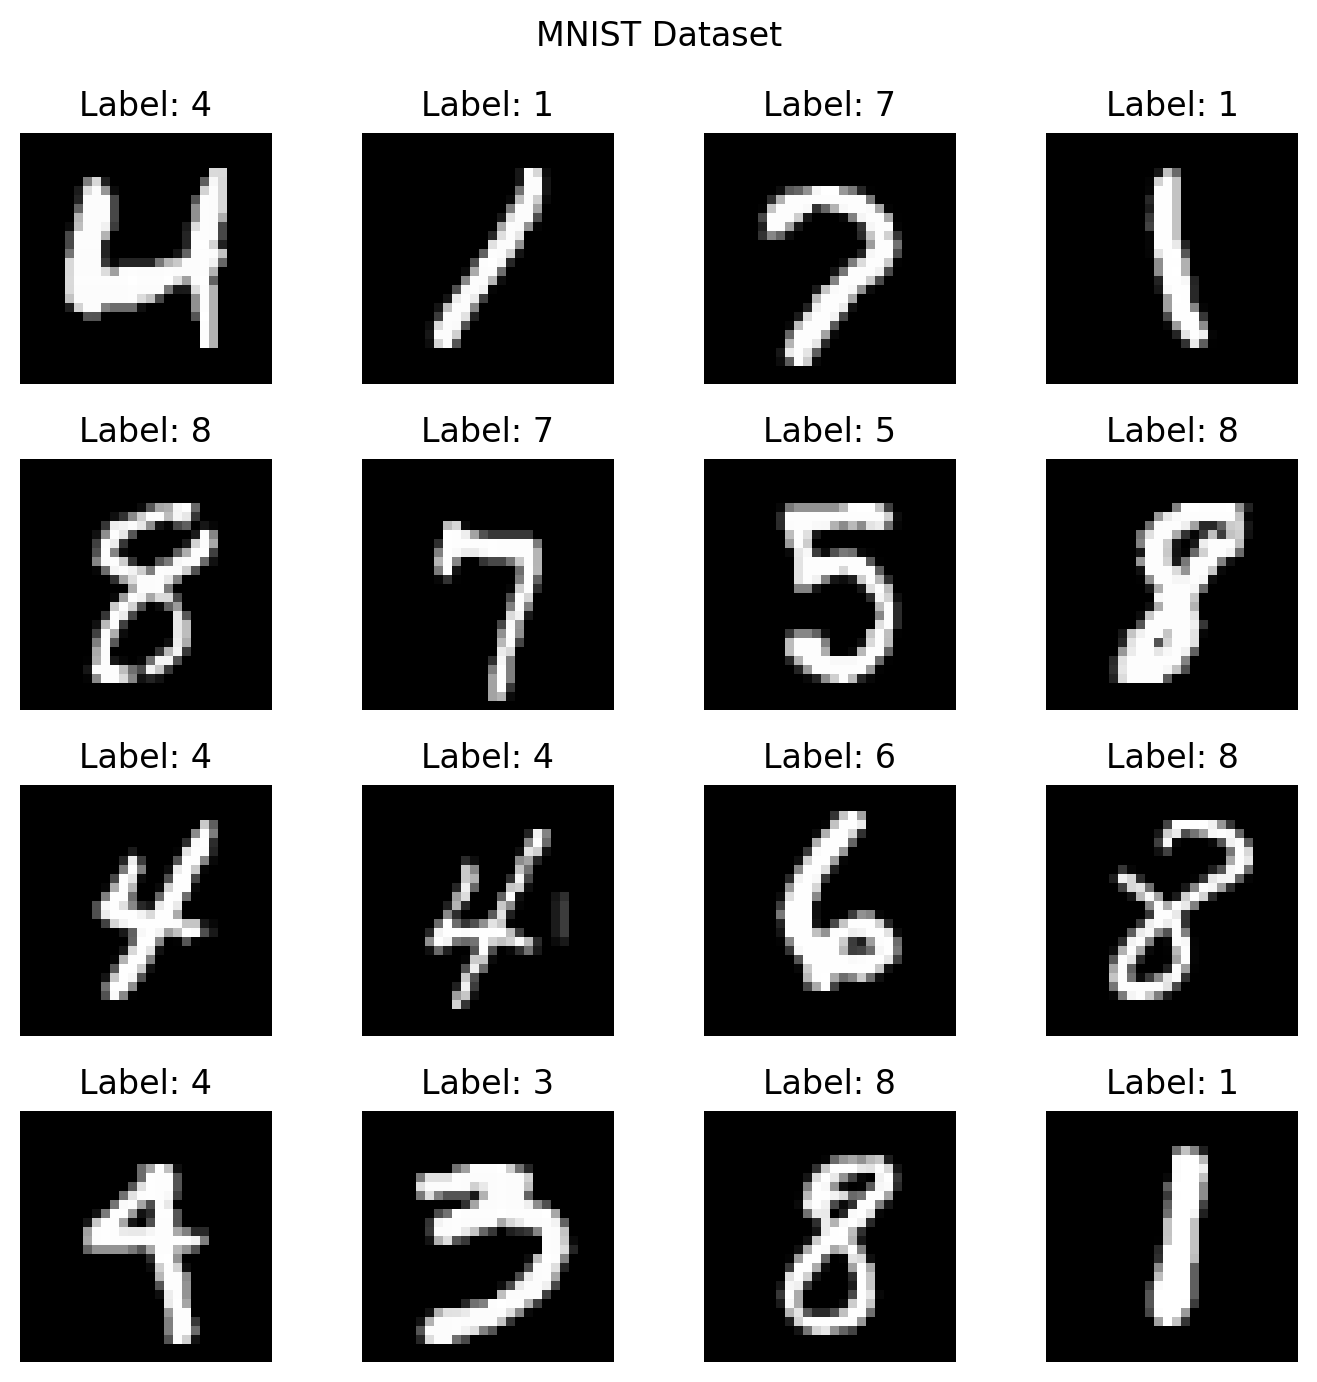

In [33]:
# 학습 데이터 내의 임의의 16개 샘플 살펴보기

# 7x7 사이즈의 새로운 figure 생성
plt.figure(figsize=(7,7))
# 16개의 랜덤한 정수 생성
random_indices = np.random.randint(0, len(X_train), size=16)

# 16개의 랜덤한 정수에 해당하는 이미지를 4x4 그리드에 하나씩 출력
for n, idx in enumerate(random_indices, start=1):
    # 4x4 그리드의 n번째 위치를 지정
    # 해당 위치에 그레이스케일 이미지를 출력하고, 타이틀로는 라벨 값을 출력
    # x축과 y축이 필요하지 않으므로 눈금 출력 생략
    plt.subplot(4,4,n)
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[idx].argmax()}")
    plt.axis('off')

plt.suptitle('MNIST Dataset')
plt.tight_layout()
plt.show()

In [34]:
def sigmoid(x):
    '''시그모이드 함수'''
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    '''시그모이드 함수의 그래디언트'''
    return (1.0 - sigmoid(x)) * sigmoid(x)

class Sigmoid():
    '''시그모이드 레이어 (시그모이드 함수의 클래스 버전)'''
    def __init__(self):
        self.out = None

    def forward(self, x):
        '''시그모이드 레이어의 순전파(forward propagation)'''
        # 순전파가 흐를 시 그 결과물을 attribute로 저장 및 리턴
        self.out = sigmoid(x)
        return self.out

    def backward(self, dout):
        '''시그모이드 레이어의 역전파(backpropagation)'''
        # 역전파가 흐를시 그 그래디언트 값을 리턴
        # dout은 sigmoid 함수의 미분값.
        dx = dout * (1.0 - self.out) * self.out ## self.out은 순전파에서의 sigmoid 함수 출력값.
        return dx

In [35]:
# 시그모이드 레이어의 순전파/역전파가 잘 작동하는지 테스트
# 임의의 사이즈에 대해 모두 동일한 크기의 결과가 출력되어야 하며, 각각 단순하게 시그모이드 함수를 적용한 값과 도함수를 적용한 값이 된다면 성공

x = np.random.randn(5, 2)
print('x =\n', x)

sigmoid_layer = Sigmoid()
print('\nsigmoid_layer.forward(x) =\n', sigmoid_layer.forward(x))
print('\nsigmoid_layer.backward(1) =\n', sigmoid_layer.backward(1)) # 최종 출력물의 미분값이 1일 경우 역전파의 결과

x =
 [[-0.10321885  0.4105985 ]
 [ 0.14404357  1.45427351]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 1.49407907 -0.20515826]]

sigmoid_layer.forward(x) =
 [[0.47421817 0.60123138]
 [0.53594876 0.81065526]
 [0.68157899 0.53038128]
 [0.60917918 0.58265313]
 [0.81668973 0.44888958]]

sigmoid_layer.backward(1) =
 [[0.2493353  0.23975221]
 [0.24870769 0.15349331]
 [0.21702907 0.24907698]
 [0.23807991 0.24316846]
 [0.14970761 0.24738772]]


In [36]:
class FCLayer():
    '''완전 연결 레이어 (Fully-Connected Layer, FC Layer)'''
    def __init__(self, input_size, output_size, weight_init_std=0.01):
        '''가중치와 편향 초기화
        input_size: 입력 데이터의 차원 수
        output_size: 출력 데이터의 차원 수
        weight_init_std: 가중치 초기화 시 사용하는 표준 편차'''
        # 가중치는 정규분포를 따르는 난수로 초기화
        self.W = np.random.randn(input_size, output_size) ## 입력의 크기(차원), 현재 층의 노드 갯수(출력 차원)
        # 편향도 정규분포를 따르는 난수로 초기화
        self.b = np.random.randn(output_size) ## 현재 층의 노드 갯수(출력 차원)

        # 역전파 계산을 위해 입력 데이터 저장
        self.x = None
        # 모델 학습을 위해 가중치와 편향의 그래디언트 저장
        self.dW = None
        self.db = None


    def forward(self, x):
        '''완전 연결 레이어의 순방향 전파(forward propagation)'''
        # 역전파 계산을 위해 입력 데이터 저장
        self.x = x
        # y = Wx + b
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout): 
        '''완전 연결 레이어의 역방향 전파(backward propagation; 역전파)'''
        # dy/dx = W  ->  dx = dy * W
        dx = np.dot(dout, self.W.T) ## 전달 받은 gradient에 현재 층의 gradient를 곱한다.(chain-rule) 다음 층으로 넘겨주는 값.
        # dy/dW = x  ->  dW = x * dy
        self.dW = np.dot(self.x.T, dout) ## weight와 bias는 현재 층의 파라미터를 업데이트 하는데 사용.
        # dy/db = 1  ->  db = dy * 1
        self.db = np.sum(dout, axis=0)

        return dx

In [37]:
# FCLayer 레이어가 임의의 입출력 데이터에 대해 잘 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 3)
print('x =\n', x)

fc_layer = FCLayer(2, 3)
print('\nfc_layer.forward(x) =\n', fc_layer.forward(x))
print('\nfc_layer.backward(y) =\n', fc_layer.backward(y))

x =
 [[ 0.3130677  -0.85409574]
 [-2.55298982  0.6536186 ]
 [ 0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567]
 [ 0.04575852 -0.18718385]]

fc_layer.forward(x) =
 [[ 1.46799167 -1.7190734   1.62817886]
 [-6.01190034  0.91385242  0.45042808]
 [ 2.40336148 -1.9130545   1.20599374]
 [ 6.03706376 -3.18300724  1.73977896]
 [ 0.11102737 -1.06432113  0.66895248]]

fc_layer.backward(y) =
 [[ 2.17336759 -1.02791573]
 [ 2.05790811  2.03279805]
 [-1.29734078 -1.42814094]
 [ 2.67540605 -1.319593  ]
 [-0.57430296  2.96331783]]


In [38]:
class MSELoss():
    '''Mean Squared Error Loss'''
    def __init__(self):
        self.loss = None    # 손실 함수 값. 역전파 계산을 위해 인스턴스 내에 저장됨
        self.y = None       # 추론값 (y)
        self.t = None       # 실제값 (target)

    def forward(self, y, t):
        '''Forward Propagation of Mean Squared Error Loss'''
        # L = 1/N * sum((y - t)^2)
        self.y = y
        self.t = t
        self.loss = np.mean((t - y) ** 2)
        return self.loss

    def backward(self, dout=1):
        '''Backward Propagation (Backpropagation) of Mean Squared Error Loss'''
        # dL/dy = 2(y - t) / N  ->  dy = 2(y - t) / N
        dx = dout * (self.y - self.t) * 2 / self.t.shape[0]
        return dx

In [39]:
class CrossEntropyLoss():
    '''교차 엔트로피(Cross Entropy) 레이어'''
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, y, t):
        '''교차 엔트로피 레이어의 순방향 전파'''
        # L = -1/N * sum(t * log(y) + (1 - t) * log(1 - y))
        self.y = y
        self.t = t
        self.loss = - np.sum(t * np.log(y + 1e-7) + (1 - t) * np.log(1 - y + 1e-7)) / len(y)
        return self.loss

    def backward(self, dout=1):
        '''교차 엔트로피 레이어의 역방향 전파'''
        # dL/dy = -t/y + (1 - t)/(1 - y)  ->  dy = (-t/y + (1 - t)/(1 - y))
        dx =  dout * (self.y - self.t) / (self.t.shape[0] * (1-self.y) * self.y + 1e-7)
        return dx

In [40]:
class MLP():
    '''다층 퍼셉트론(Multi Layer Perceptron, MLP) 모델'''
    def __init__(self, input_size, hidden_size_list, output_size, loss_type='MSE'):
        '''신경망의 구조와 손실 함수 정의
        input_size: 입력 데이터의 차원 수
        hidden_size_list: 은닉층 차원 수의 리스트 (e.g. [100, 100, 100])
        output_size: 출력 데이터의 차원 수
        loss_type: 손실 함수의 종류 ('MSE' or 'CrossEntropy')
        '''

        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.output_size = output_size
        self.hidden_layer_num = len(hidden_size_list)
        self.loss_type = loss_type

        ### 레이어 쌓기 : FCLayer -> Sigmoid -> ... -> FCLayer -> Sigmoid
        # 입력층
        self.layers = [
            FCLayer(input_size, hidden_size_list[0]),
            Sigmoid()
        ]
        # 은닉층
        for idx in range(1, self.hidden_layer_num):
            self.layers.append(FCLayer(hidden_size_list[idx-1], hidden_size_list[idx]))
            self.layers.append(Sigmoid())
        # 출력층
        self.layers.append(FCLayer(hidden_size_list[-1], output_size))
        self.layers.append(Sigmoid())

        # 인자로 받은 `loss_type`에 맞게 손실 함수 레이어 정하기
        if self.loss_type == 'MSE':
            self.loss_layer = MSELoss()
        elif self.loss_type == 'CrossEntropy':
            self.loss_layer = CrossEntropyLoss()
        else:
            self.loss_layer = None


        self.loss = None

    def predict(self, x):
        '''입력값을 받았을 때 순방향 전파를 통한 출력물 산출(예측)'''
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        '''MLP 모델의 순방향 전파'''
        y = self.predict(x)
        self.loss = self.loss_layer.forward(y, t)
        return self.loss

    def backward(self, dout=1):
        '''MLP 모델의 역방향 전파'''
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers): ## 출력층 --> 입력층 으로 역순(reversed).
            dout = layer.backward(dout)
        return dout

In [41]:
# 임의의 입출력 데이터와 하이퍼파라미터에 대해 MLP 모델이 에러 없이 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 1)
print('x =\n', x)

mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type='MSE')
print('\nmlp.predict(x) =\n', mlp.predict(x))
print('\nmlp.forward(x, y) =\n', mlp.forward(x, y))
print('\nmlp.backward() =\n', mlp.backward())

x =
 [[-0.51080514 -1.18063218]
 [-0.02818223  0.42833187]
 [ 0.06651722  0.3024719 ]
 [-0.63432209 -0.36274117]
 [-0.67246045 -0.35955316]]

mlp.predict(x) =
 [[0.09179987]
 [0.0957102 ]
 [0.09523428]
 [0.09244939]
 [0.09246448]]

mlp.forward(x, y) =
 1.4714343261962757

mlp.backward() =
 [[-3.38789968e-04 -3.67465930e-04]
 [ 1.17086873e-03  3.64237844e-03]
 [-5.29701613e-05 -1.65101162e-04]
 [-3.87903857e-05  4.80263293e-04]
 [-1.30842487e-04  1.66334466e-03]]


In [42]:
# one-hot 인코딩이 되어 있는 값을 다시 라벨로 바꾸어 비교
def accuracy(y, t):
    '''정확도 함수'''
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)
    return np.sum(y == t) / float(len(t))

In [43]:
# 네트워크 구조를 정하기 위한 하이퍼파라미터 (784 -> 64 -> 16 -> 10)
n_input = 784
n_hidden = (64,16,)
n_output = 10

# 학습에 필요한 하이퍼파라미터
batch_size = 128
n_epochs = 30
print_every = 1
learning_rate_mse = 3
learning_rate_ce = 0.5

In [44]:
# MSE 손실 함수를 사용하는 MLP 모델
mlp_mse = MLP(n_input, n_hidden, n_output, loss_type='MSE')

# Cross Entropy 손실 함수를 사용하는 MLP 모델
mlp_ce = MLP(n_input, n_hidden, n_output, loss_type='CrossEntropy')

In [45]:
def training(model, learning_rate, X_train, y_train, X_test, y_test):
    '''모델 학습 함수'''
    training_errors, training_accs = [], [] # 학습 손실 및 정확도
    test_errors, test_accs = [], []         # 테스트 손실 및 정확도

    # 학습 과정 : n_epochs만큼 반복
    for epoch in tqdm(range(n_epochs)):
        # 학습 데이터를 랜덤하게 섞음
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        # 미니배치 학습
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # 순전파
            model.forward(X_batch, y_batch)

            # 역전파
            model.backward()

            # 모델 파라미터 업데이트
            for layer in model.layers:
                if isinstance(layer, FCLayer):
                    layer.W -= learning_rate * layer.dW
                    layer.b -= learning_rate * layer.db

        # 학습 과정 출력 : print_every의 배수에 해당할 때마다 출력
        if (epoch+1) % print_every == 0:
            # 모든 학습 데이터에 대한 손실과 정확도 계산
            model.forward(X_train, y_train)
            training_errors.append(model.loss)
            training_accs.append(accuracy(model.predict(X_train), y_train))

            # 모든 테스트 데이터에 대한 손실과 정확도 계산
            model.forward(X_test, y_test)
            test_errors.append(model.loss)
            test_accs.append(accuracy(model.predict(X_test), y_test))

            # 학습 과정 출력
            print('[Epoch {}/{}] Training Loss = {:.4f} / Training Acc = {:.2f}% /'
                  'Test Loss = {:.4f} / Test Acc = {:.2f}%'.format(
                      epoch+1, n_epochs,
                      training_errors[-1], training_accs[-1]*100,
                      test_errors[-1], test_accs[-1]*100))

    return np.asarray([training_errors, test_errors, training_accs, test_accs])

In [46]:
# MSE 손실 함수를 사용하는 모델 학습
training_result_mse = training(mlp_mse, learning_rate_mse, X_train, y_train, X_test, y_test)

[Epoch 1/30] Training Loss = 0.0264 / Training Acc = 83.52% /Test Loss = 0.0255 / Test Acc = 84.25%


[Epoch 2/30] Training Loss = 0.0183 / Training Acc = 88.44% /Test Loss = 0.0179 / Test Acc = 88.67%


[Epoch 3/30] Training Loss = 0.0155 / Training Acc = 90.11% /Test Loss = 0.0154 / Test Acc = 90.36%


[Epoch 4/30] Training Loss = 0.0131 / Training Acc = 91.72% /Test Loss = 0.0135 / Test Acc = 91.28%


[Epoch 5/30] Training Loss = 0.0118 / Training Acc = 92.64% /Test Loss = 0.0126 / Test Acc = 91.95%


[Epoch 6/30] Training Loss = 0.0109 / Training Acc = 93.25% /Test Loss = 0.0118 / Test Acc = 92.42%


[Epoch 7/30] Training Loss = 0.0100 / Training Acc = 93.82% /Test Loss = 0.0114 / Test Acc = 92.60%


[Epoch 8/30] Training Loss = 0.0092 / Training Acc = 94.32% /Test Loss = 0.0107 / Test Acc = 93.07%


[Epoch 9/30] Training Loss = 0.0091 / Training Acc = 94.48% /Test Loss = 0.0108 / Test Acc = 93.04%


[Epoch 10/30] Training Loss = 0.0081 / Training Acc = 95.08% /Test Loss = 0.0100 / Test Acc = 93.61%


[Epoch 11/30] Training Loss = 0.0077 / Training Acc = 95.30% /Test Loss = 0.0097 / Test Acc = 93.89%


[Epoch 12/30] Training Loss = 0.0073 / Training Acc = 95.56% /Test Loss = 0.0094 / Test Acc = 94.22%


[Epoch 13/30] Training Loss = 0.0074 / Training Acc = 95.52% /Test Loss = 0.0096 / Test Acc = 93.96%


[Epoch 14/30] Training Loss = 0.0069 / Training Acc = 95.88% /Test Loss = 0.0092 / Test Acc = 94.10%


[Epoch 15/30] Training Loss = 0.0065 / Training Acc = 96.05% /Test Loss = 0.0090 / Test Acc = 94.21%


[Epoch 16/30] Training Loss = 0.0062 / Training Acc = 96.30% /Test Loss = 0.0090 / Test Acc = 94.38%


[Epoch 17/30] Training Loss = 0.0061 / Training Acc = 96.39% /Test Loss = 0.0088 / Test Acc = 94.41%


[Epoch 18/30] Training Loss = 0.0061 / Training Acc = 96.38% /Test Loss = 0.0091 / Test Acc = 94.26%


[Epoch 19/30] Training Loss = 0.0057 / Training Acc = 96.61% /Test Loss = 0.0088 / Test Acc = 94.48%


[Epoch 20/30] Training Loss = 0.0058 / Training Acc = 96.53% /Test Loss = 0.0090 / Test Acc = 94.26%


[Epoch 21/30] Training Loss = 0.0054 / Training Acc = 96.85% /Test Loss = 0.0086 / Test Acc = 94.55%


[Epoch 22/30] Training Loss = 0.0053 / Training Acc = 96.91% /Test Loss = 0.0087 / Test Acc = 94.48%


[Epoch 23/30] Training Loss = 0.0051 / Training Acc = 96.94% /Test Loss = 0.0086 / Test Acc = 94.52%


[Epoch 24/30] Training Loss = 0.0049 / Training Acc = 97.12% /Test Loss = 0.0084 / Test Acc = 94.65%


[Epoch 25/30] Training Loss = 0.0048 / Training Acc = 97.18% /Test Loss = 0.0083 / Test Acc = 94.72%


[Epoch 26/30] Training Loss = 0.0047 / Training Acc = 97.22% /Test Loss = 0.0084 / Test Acc = 94.73%


[Epoch 27/30] Training Loss = 0.0045 / Training Acc = 97.35% /Test Loss = 0.0083 / Test Acc = 94.68%


[Epoch 28/30] Training Loss = 0.0045 / Training Acc = 97.35% /Test Loss = 0.0081 / Test Acc = 94.88%


[Epoch 29/30] Training Loss = 0.0043 / Training Acc = 97.50% /Test Loss = 0.0082 / Test Acc = 94.74%



100%|██████████| 30/30 [00:28<00:00,  1.05it/s]

[Epoch 30/30] Training Loss = 0.0043 / Training Acc = 97.47% /Test Loss = 0.0082 / Test Acc = 94.68%


In [47]:
training_result_ce = training(mlp_ce, learning_rate_ce, X_train, y_train, X_test, y_test)

[Epoch 1/30] Training Loss = 1.2817 / Training Acc = 78.35% /Test Loss = 1.2592 / Test Acc = 79.07%


[Epoch 2/30] Training Loss = 0.9221 / Training Acc = 85.28% /Test Loss = 0.9070 / Test Acc = 85.67%


[Epoch 3/30] Training Loss = 0.7580 / Training Acc = 88.09% /Test Loss = 0.7579 / Test Acc = 87.85%


[Epoch 4/30] Training Loss = 0.6576 / Training Acc = 89.78% /Test Loss = 0.6735 / Test Acc = 89.48%


[Epoch 5/30] Training Loss = 0.5894 / Training Acc = 90.89% /Test Loss = 0.6122 / Test Acc = 90.49%


[Epoch 6/30] Training Loss = 0.5411 / Training Acc = 91.71% /Test Loss = 0.5706 / Test Acc = 91.30%


[Epoch 7/30] Training Loss = 0.5020 / Training Acc = 92.35% /Test Loss = 0.5382 / Test Acc = 91.67%


[Epoch 8/30] Training Loss = 0.4738 / Training Acc = 92.78% /Test Loss = 0.5154 / Test Acc = 92.13%


[Epoch 9/30] Training Loss = 0.4426 / Training Acc = 93.34% /Test Loss = 0.4928 / Test Acc = 92.31%


[Epoch 10/30] Training Loss = 0.4239 / Training Acc = 93.69% /Test Loss = 0.4703 / Test Acc = 92.66%


[Epoch 11/30] Training Loss = 0.3990 / Training Acc = 94.11% /Test Loss = 0.4594 / Test Acc = 93.09%


[Epoch 12/30] Training Loss = 0.3824 / Training Acc = 94.38% /Test Loss = 0.4462 / Test Acc = 93.12%


[Epoch 13/30] Training Loss = 0.3677 / Training Acc = 94.62% /Test Loss = 0.4353 / Test Acc = 93.43%


[Epoch 14/30] Training Loss = 0.3595 / Training Acc = 94.71% /Test Loss = 0.4331 / Test Acc = 93.41%


[Epoch 15/30] Training Loss = 0.3485 / Training Acc = 94.86% /Test Loss = 0.4274 / Test Acc = 93.48%


[Epoch 16/30] Training Loss = 0.3341 / Training Acc = 95.18% /Test Loss = 0.4145 / Test Acc = 93.70%


[Epoch 17/30] Training Loss = 0.3254 / Training Acc = 95.28% /Test Loss = 0.4119 / Test Acc = 93.75%


[Epoch 18/30] Training Loss = 0.3126 / Training Acc = 95.48% /Test Loss = 0.4050 / Test Acc = 93.86%


[Epoch 19/30] Training Loss = 0.3018 / Training Acc = 95.64% /Test Loss = 0.3918 / Test Acc = 94.15%


[Epoch 20/30] Training Loss = 0.2981 / Training Acc = 95.74% /Test Loss = 0.3927 / Test Acc = 94.21%


[Epoch 21/30] Training Loss = 0.2881 / Training Acc = 95.87% /Test Loss = 0.3849 / Test Acc = 94.17%


[Epoch 22/30] Training Loss = 0.2793 / Training Acc = 96.05% /Test Loss = 0.3797 / Test Acc = 94.26%


[Epoch 23/30] Training Loss = 0.2729 / Training Acc = 96.20% /Test Loss = 0.3779 / Test Acc = 94.43%


[Epoch 24/30] Training Loss = 0.2687 / Training Acc = 96.20% /Test Loss = 0.3792 / Test Acc = 94.26%


[Epoch 25/30] Training Loss = 0.2590 / Training Acc = 96.33% /Test Loss = 0.3752 / Test Acc = 94.29%


[Epoch 26/30] Training Loss = 0.2513 / Training Acc = 96.54% /Test Loss = 0.3678 / Test Acc = 94.50%


[Epoch 27/30] Training Loss = 0.2477 / Training Acc = 96.61% /Test Loss = 0.3719 / Test Acc = 94.42%


[Epoch 28/30] Training Loss = 0.2400 / Training Acc = 96.65% /Test Loss = 0.3657 / Test Acc = 94.48%


[Epoch 29/30] Training Loss = 0.2398 / Training Acc = 96.64% /Test Loss = 0.3667 / Test Acc = 94.42%



100%|██████████| 30/30 [00:29<00:00,  1.01it/s]

[Epoch 30/30] Training Loss = 0.2402 / Training Acc = 96.61% /Test Loss = 0.3690 / Test Acc = 94.44%


Exception ignored in: <function tqdm.__del__ at 0x7f5f159cbee0>
Traceback (most recent call last):
  File "/home/pervinco/miniconda3/envs/AiLab/lib/python3.8/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/pervinco/miniconda3/envs/AiLab/lib/python3.8/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


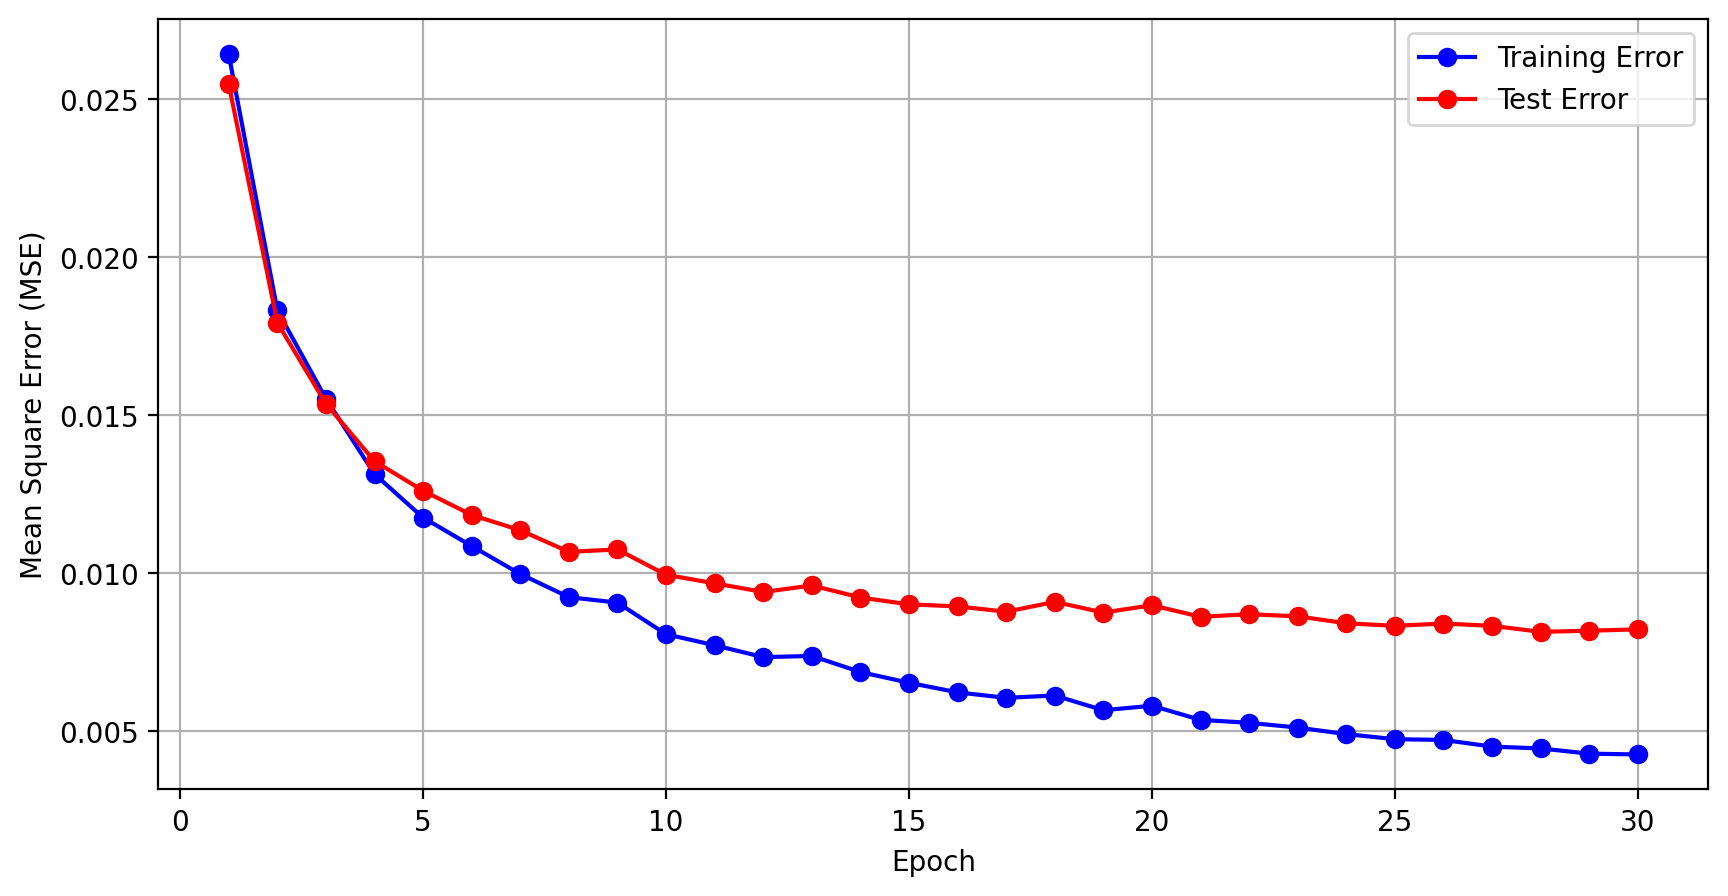

In [48]:
# 학습 및 테스트 에러 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1,n_epochs+1), training_result_mse[0], 'bo-', label='Training Error')
plt.plot(range(1,n_epochs+1), training_result_mse[1], 'ro-', label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

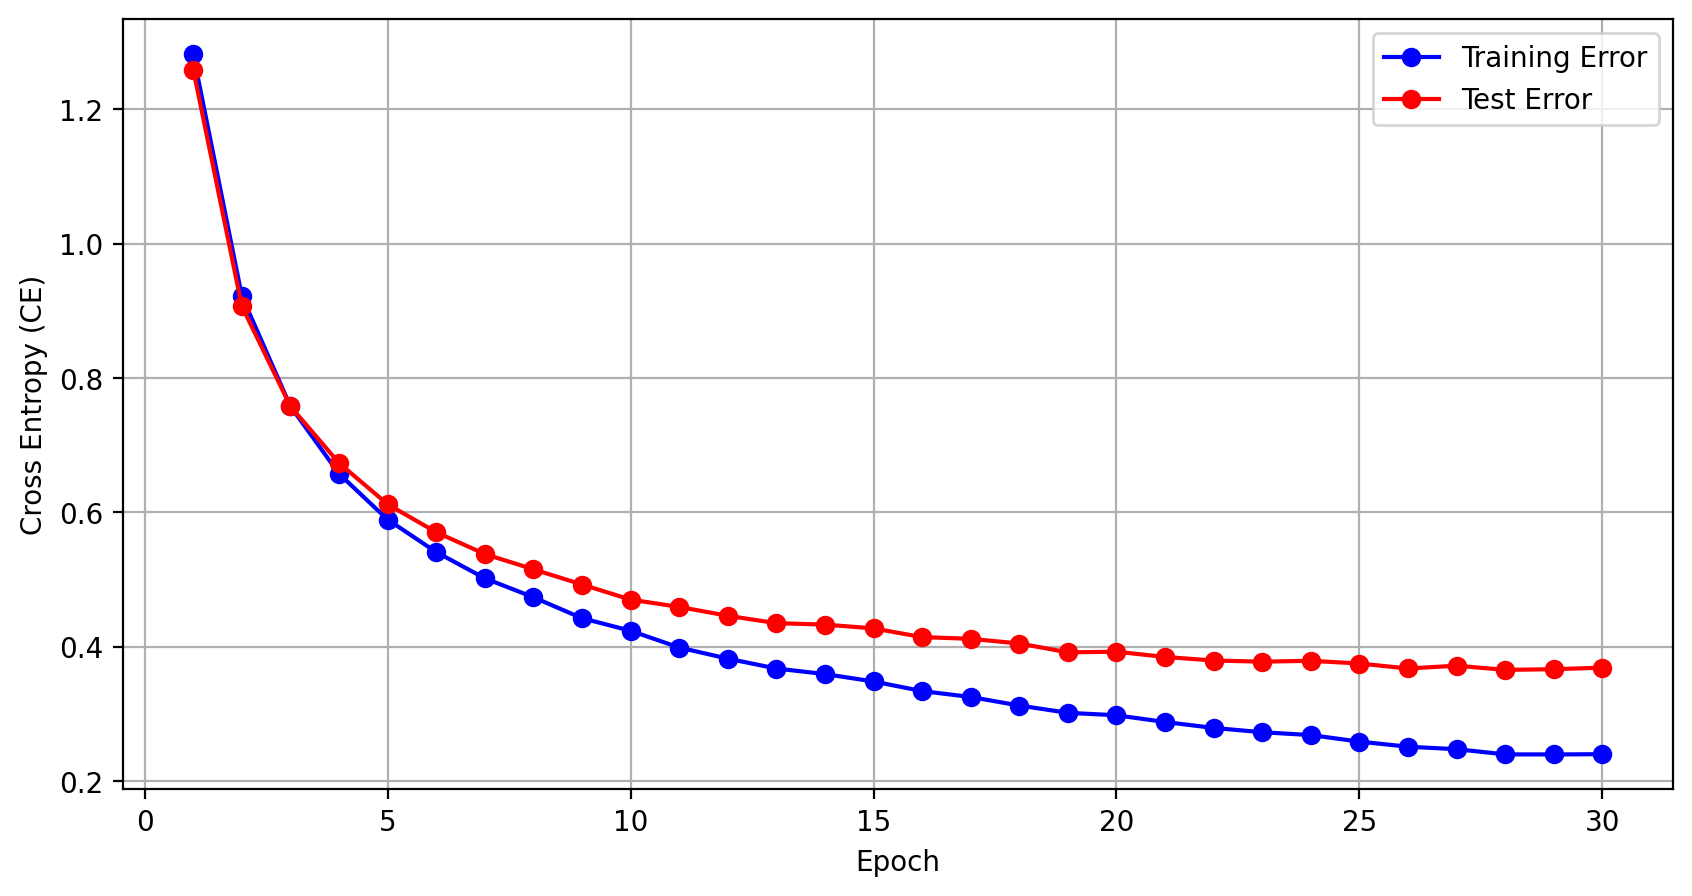

In [49]:
# 학습 및 테스트 에러 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1,n_epochs+1), training_result_ce[0], 'bo-', label='Training Error')
plt.plot(range(1,n_epochs+1), training_result_ce[1], 'ro-', label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy (CE)')
plt.grid(True)
plt.legend()
plt.show()

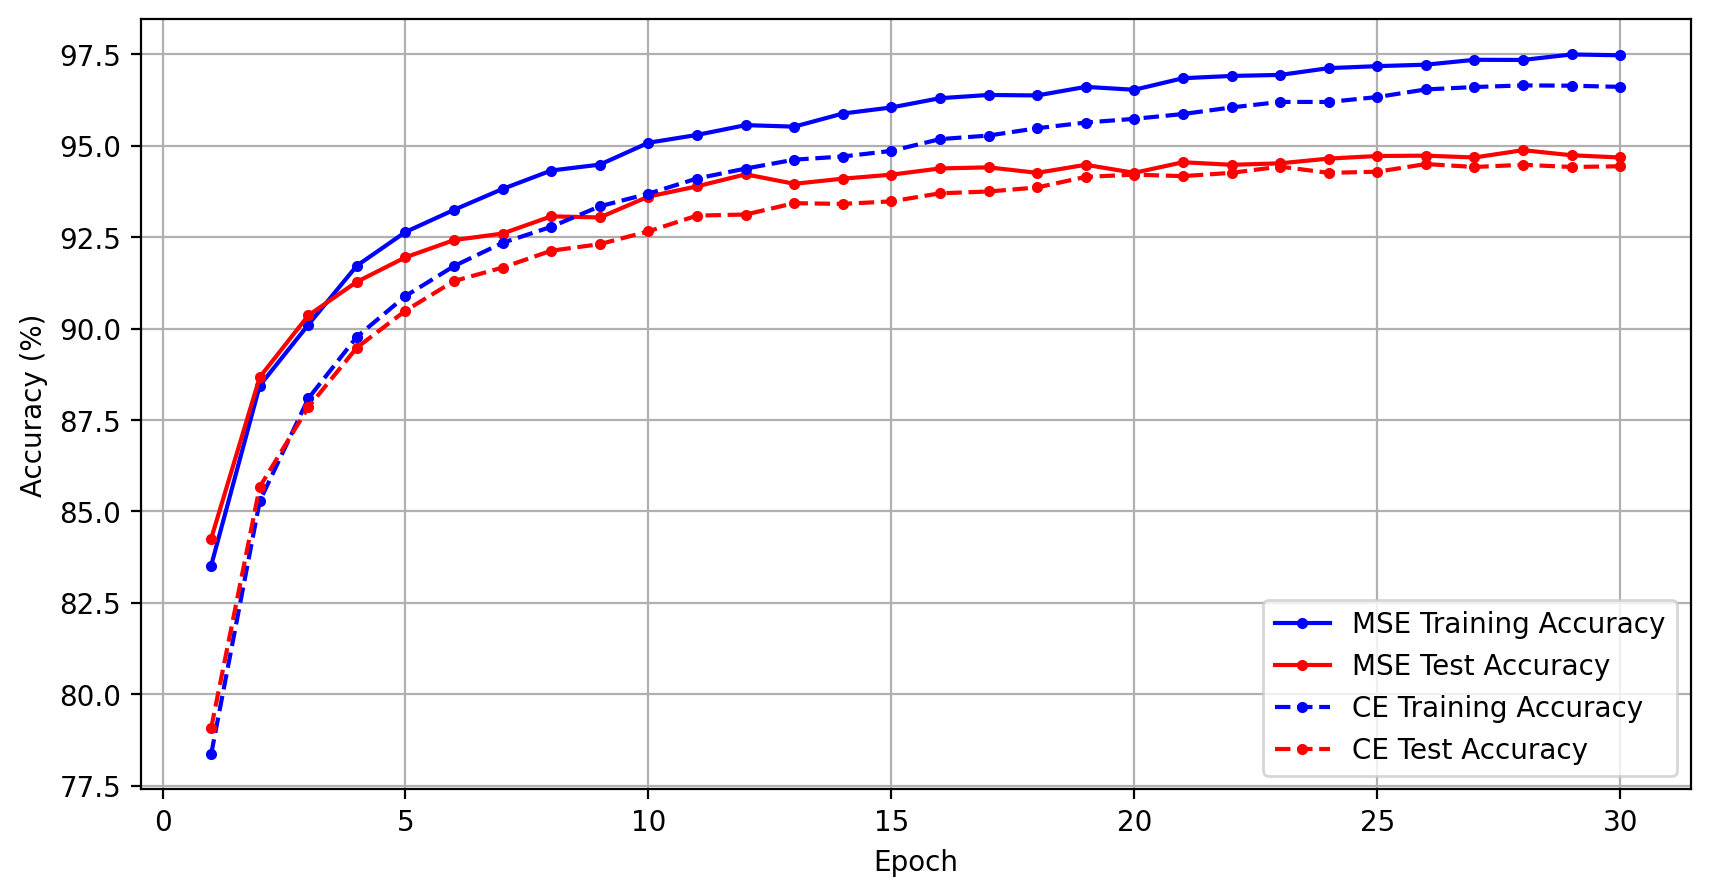

In [50]:
# 학습 및 테스트 정확도 시각화하기
plt.figure(figsize=(10, 5))
plt.plot(range(1,n_epochs+1), training_result_mse[2]*100, 'b.-', label='MSE Training Accuracy')
plt.plot(range(1,n_epochs+1), training_result_mse[3]*100, 'r.-', label='MSE Test Accuracy')
plt.plot(range(1,n_epochs+1), training_result_ce[2]*100, 'b.--', label='CE Training Accuracy')
plt.plot(range(1,n_epochs+1), training_result_ce[3]*100, 'r.--', label='CE Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

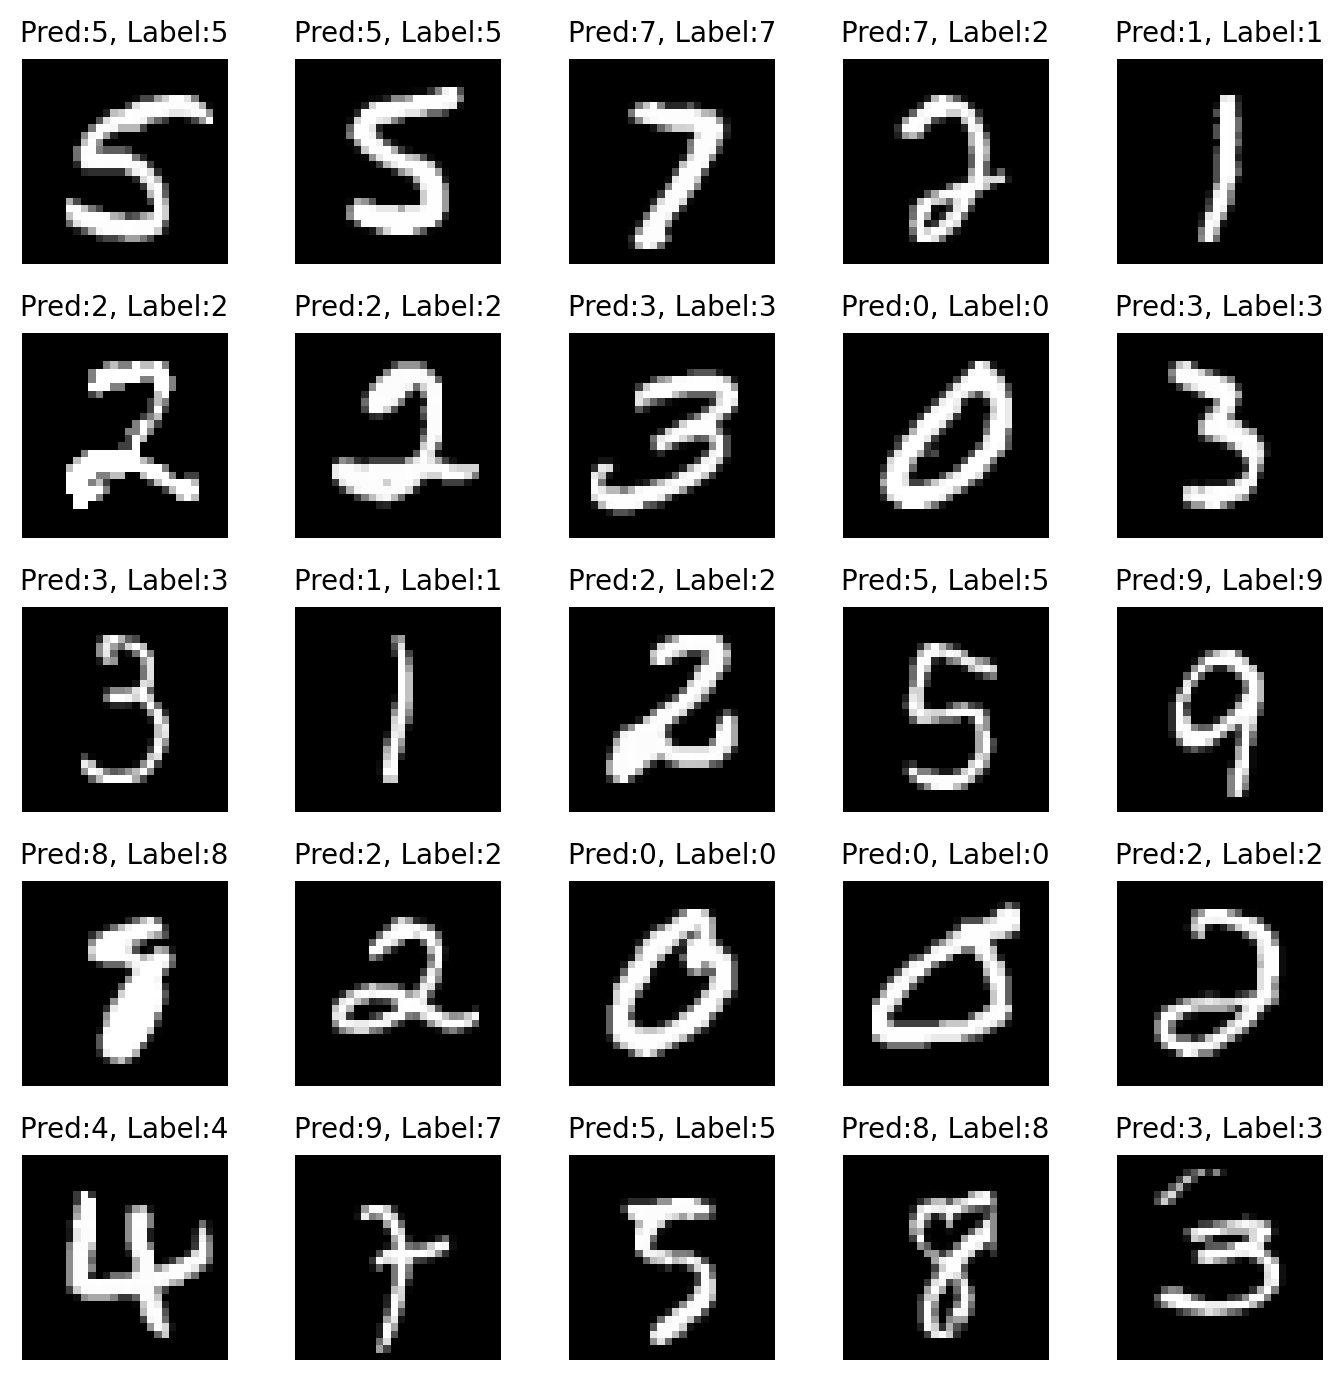

In [51]:
# 25개의 임의의 테스트 데이터에 대한 분류 결과 시각화하기
n_sample = 25  # number of samples

# 테스트셋으로부터 임의의 25개의 이미지 추출 및 이에 대응하는 라벨과 모델 결과 생성
sample_indices = np.random.choice(len(y_test), n_sample, replace=False)
sample_images = X_test[sample_indices].reshape((-1,28,28))
sample_labels = np.argmax(y_test[sample_indices], axis=1)
sample_pred = np.argmax(mlp_mse.predict(X_test[sample_indices]), axis=1)

# 7x7 사이즈의 새로운 figure 생성
plt.figure(figsize=(7,7))
for idx in range(n_sample):
    # 5x5 그리드의 (idx+1)번째 위치에 그래이스케일 이미지를 출력
    # 타이틀로는 모델의 예측값과 실제값을 출력
    plt.subplot(5, 5, idx+1)
    plt.imshow(sample_images[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(sample_pred[idx], sample_labels[idx]), fontsize=10)

plt.tight_layout()
plt.show()


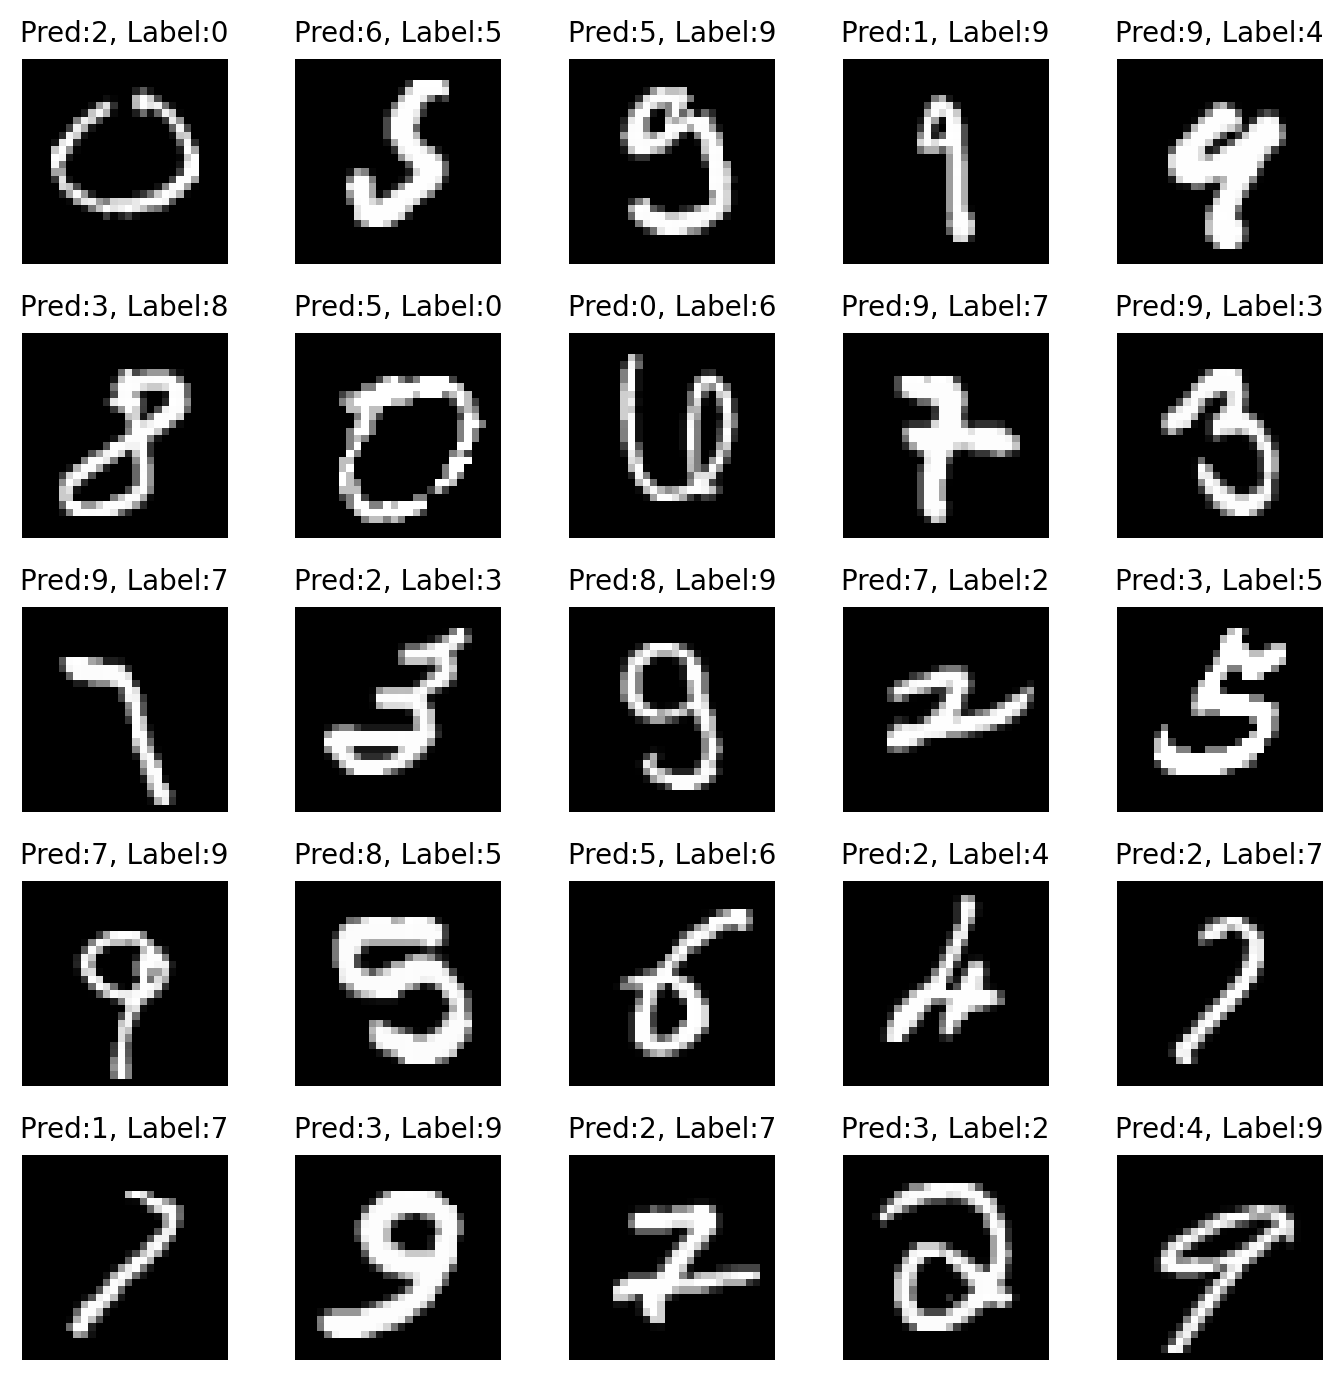

In [52]:
# 25개의 오답 데이터에 대한 분류 결과 시각화하기
n_sample = 25  # number of samples

# 테스트셋으로부터 틀린 25개의 이미지 추출 및 이에 대응하는 라벨과 모델 결과 생성
pred_result = np.argmax(mlp_mse.predict(X_test), axis=1)
wrong_indices = np.where(pred_result != np.argmax(y_test, axis=1))[0]
sample_indices = np.random.choice(wrong_indices, n_sample, replace=False)
sample_images = X_test[sample_indices].reshape((-1,28,28))
sample_labels = np.argmax(y_test[sample_indices], axis=1)
sample_pred = pred_result[sample_indices]

# 7x7 사이즈의 새로운 figure 생성
plt.figure(figsize=(7,7))
for idx in range(n_sample):
    # 5x5 그리드의 (idx+1)번째 위치에 그래이스케일 이미지를 출력
    # 타이틀로는 모델의 예측값과 실제값을 출력
    plt.subplot(5, 5, idx+1)
    plt.imshow(sample_images[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(sample_pred[idx], sample_labels[idx]), fontsize=10)

plt.tight_layout()
plt.show()
